In [91]:
import numpy as np
from scipy import optimize
from scipy.stats import multivariate_normal, norm
from scipy.integrate import dblquad, tplquad
import matplotlib.pyplot as plt
from itertools import product

In [92]:
class Buyer:
  def __init__(self, mu, sigma):
    """
    Buyer using a multivariate normal distribution for valuations.
    :param mu: Mean vector (list or 1D numpy array) (distinct valuations for each item)
    :param sigma: Covariance matrix (2D numpy array)
    """
    self.mu = np.array(mu)
    self.sigma = np.array(sigma)
    self.dimension = self.mu.shape[0]

    # Validate that the covariance matrix is square and matches the mean vector
    if self.sigma.shape != (self.dimension, self.dimension):
      raise ValueError("Covariance matrix shape must match (len(mu), len(mu))")

In [155]:
class MultipleProductsEnv:
    def __init__(self, buyer: Buyer, num_products, prices):
        """
        Environment with multiple products.
        :param buyer: Instance of Buyer class
        """
        self.buyer = buyer
        self.num_products = num_products
        self.prices = prices
    
    def round(self, prices, valuations):
        coeff = (valuations > prices).astype(int)
        revenue = np.sum(prices * coeff)
        return coeff, revenue
    
    def get_prices(self):
        print("Prices:", self.prices)

    def get_valuations(self):
        return np.random.multivariate_normal(self.buyer.mu, self.buyer.sigma)


In [154]:
def compute_baseline(mu, sigma, prices, T=1000):
    
    valuations = np.random.multivariate_normal(mu, sigma, size=T)
    
    num_samples, num_products = valuations.shape
    num_discrete_prices = len(prices)

    max_total_revenue = -np.inf
    optimal_price_vector = None

    for price_combination_indices in product(range(num_discrete_prices), repeat=num_products):
        # Convertiamo gli indici in prezzi reali per la combinazione corrente
        current_prices = prices[list(price_combination_indices)]
        
        current_total_revenue = 0
        # Per ogni combinazione di prezzi, simuliamo il ricavo su tutti i T campioni (round)
        for t in range(num_samples):
            # Otteniamo le valutazioni del cliente per il round corrente
            current_valuation = valuations[t, :]
            
            # Verifichiamo quali articoli vengono acquistati.
            # 'purchased_items_mask' sarà un array booleano: True se valuation >= price, False altrimenti.
            purchased_items_mask = current_valuation >= current_prices
            
            # Calcoliamo il ricavo per questo round sommando i prezzi degli articoli acquistati.
            # np.sum(current_prices[purchased_items_mask]) somma solo gli elementi
            # di 'current_prices' dove la maschera è True.
            revenue_this_round = np.sum(current_prices[purchased_items_mask])
            
            # Aggiungiamo il ricavo del round al totale corrente per questa combinazione di prezzi
            current_total_revenue += revenue_this_round
            
        # Dopo aver calcolato il ricavo totale per tutti i campioni con 'current_prices',
        # controlliamo se questa combinazione ha superato il ricavo massimo trovato finora.
        if current_total_revenue > max_total_revenue:
            max_total_revenue = current_total_revenue
            # Facciamo una copia per assicurarci di salvare i prezzi corretti
            optimal_price_vector = current_prices.copy()

    return optimal_price_vector, max_total_revenue
    

In [195]:
class CombUCB1Agent:
    def __init__(self, K, B, T, N, range=1):
        self.K = K #number of arms
        self.T = T #number of rounds
        self.N = N #number of products
        self.range = range  # range of the rewards
        self.S_t = None # super_arm index
        self.avg_f = np.zeros((N, K)) # average rewards for each product
        self.avg_c = np.zeros((N, K)) # average costs for each product
        self.N_pulls = np.zeros((N, K)) # number of pulls for each product
        self.budget = B
        self.rho = B/T
        self.t = 0

    def pull_arm(self):
        if self.budget < 1:
            self.S_t = np.zeros(self.N)
            return self.S_t
        else:
            f_ucbs = self.avg_f + self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-10))
            c_lcbs = self.avg_c - self.range * np.sqrt(2 * np.log(self.T) / (self.N_pulls + 1e-10))
            gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)
            self.S_t = np.zeros(self.N)
            for i in range(self.N):
                gamma_t = gamma_m[i]
                self.S_t[i] = np.random.choice(self.K, p=gamma_t)
        return self.S_t  # this contains the indexes of the prices for each product
    
    def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):
        """
        f_ucbs_matrix: shape (N, K) - objective vectors for each product
        c_lcbs_matrix: shape (N, K) - constraint vectors for each product
        returns: gamma_matrix of shape (N, K) - optimal distributions
        """
        N, K = f_ucbs_matrix.shape
        gamma_matrix = np.zeros((N, K))
        for i in range(N):
            f_ucbs = f_ucbs_matrix[i]
            c_lcbs = c_lcbs_matrix[i]
            if np.all(c_lcbs <= 0):
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                continue
            c = -f_ucbs
            A_ub = [c_lcbs]
            b_ub = [self.rho]
            A_eq = [np.ones(K)]
            b_eq = [1]
            bounds = [(0, 1) for _ in range(K)]
            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')
            if res.success:
                gamma_matrix[i] = res.x
            else:
                raise ValueError(f"LP failed for product {i}: {res.message}")
        return gamma_matrix
    
    def update(self, f_t, sold):
        
        #Update of n_pulls
        for prod in range(self.N):
            if sold[prod] == 1:
                pulled_arm = int(self.S_t[prod])
                self.N_pulls[prod, pulled_arm] += 1
                self.avg_f[prod, pulled_arm] += (f_t - self.avg_f[prod, pulled_arm]) / self.N_pulls[prod, pulled_arm]

        #self.N_pulls[self.S_t] += 1
        #self.avg_f[self.S_t] += (f_t - self.avg_f[self.S_t]) / self.N_pulls[self.S_t]
        #self.avg_c[self.p_t] += (c_t - self.avg_c[self.p_t])/self.N_pulls[self.p_t]
        
        self.budget -= np.sum(sold)
        self.t += 1
'''
    def pull_arm(self):
    if self.budget < 1:
      self.s_t = np.zeros(self.N)
      return self.s_t
    else:
      f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
      c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
      gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)
      print("gamma_m", gamma_m)
      self.s_t = np.zeros(self.N)
      for i in range(self.N):
        gamma_t = gamma_m[i]
        self.s_t[i] = np.random.choice(self.K, p=gamma_t)
    return self.s_t #this contains the prices for each product

  def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):
        """
        f_ucbs_matrix: shape (N, K) - objective vectors for each product
        c_lcbs_matrix: shape (N, K) - constraint vectors for each product
        returns: gamma_matrix of shape (N, K) - optimal distributions
        """
        N, K = f_ucbs_matrix.shape
        gamma_matrix = np.zeros((N, K))

        for i in range(N):
            f_ucbs = f_ucbs_matrix[i]
            c_lcbs = c_lcbs_matrix[i]
            rho = self.rho

            # Special case: no cost constraint needed
            if np.all(c_lcbs <= 0):
                gamma = np.zeros(K)
                gamma[np.argmax(f_ucbs)] = 1.0
                gamma_matrix[i] = gamma
                continue

            # Set up the LP
            c = -f_ucbs
            A_ub = [c_lcbs]
            b_ub = [rho]
            A_eq = [np.ones(K)]
            b_eq = [1]
            bounds = [(0, 1) for _ in range(K)]

            res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub,
                                   A_eq=A_eq, b_eq=b_eq, bounds=bounds, method='highs')

            if res.success:
                gamma_matrix[i] = res.x
            else:
                raise ValueError(f"LP failed for product {i}: {res.message}")

        return gamma_matrix

  def update(self, f_t, c_t=1):
    self.N_pulls[self.s_t] += 1
    self.avg_f[self.s_t] += (f_t - self.avg_f[self.s_t])/self.N_pulls[self.s_t]
    #self.avg_c[self.p_t] += (c_t - self.avg_c[self.p_t])/self.N_pulls[self.p_t]
    self.budget -= 1
    self.t += 1
'''


  


'\n    def pull_arm(self):\n    if self.budget < 1:\n      self.s_t = np.zeros(self.N)\n      return self.s_t\n    else:\n      f_ucbs = self.avg_f + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)\n      c_lcbs = self.avg_c - self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)\n      gamma_m = self.compute_combinatorial_opt(f_ucbs, c_lcbs)\n      print("gamma_m", gamma_m)\n      self.s_t = np.zeros(self.N)\n      for i in range(self.N):\n        gamma_t = gamma_m[i]\n        self.s_t[i] = np.random.choice(self.K, p=gamma_t)\n    return self.s_t #this contains the prices for each product\n\n  def compute_combinatorial_opt(self, f_ucbs_matrix, c_lcbs_matrix):\n        """\n        f_ucbs_matrix: shape (N, K) - objective vectors for each product\n        c_lcbs_matrix: shape (N, K) - constraint vectors for each product\n        returns: gamma_matrix of shape (N, K) - optimal distributions\n        """\n        N, K = f_ucbs_matrix.shape\n        gamma_matrix = np.zeros((N, K))\n\n       

Trial:  0
12222.222222222219
2097.8888888888887
Trial:  1
12222.222222222219
2028.888888888889
Trial:  2
12222.222222222219
2021.3333333333335
Trial:  3
12222.222222222219
2061.333333333333
Trial:  4
12222.222222222219
2005.4444444444443
Trial:  5
12222.222222222219
1991.2222222222222
Trial:  6
12222.222222222219
1995.9999999999998
Trial:  7
12222.222222222219
1998.3333333333333
Trial:  8
12222.222222222219
2033.3333333333333
Trial:  9
12222.222222222219
2038.0
Trial:  10
12222.222222222219
1933.7777777777776
Trial:  11
12222.222222222219
2018.2222222222222
Trial:  12
12222.222222222219
2158.3333333333335
Trial:  13
12222.222222222219
2138.111111111111
Trial:  14
12222.222222222219
2049.0
Trial:  15
12222.222222222219
2072.5555555555557
Trial:  16
12222.222222222219
2061.777777777778
Trial:  17
12222.222222222219
2054.6666666666665
Trial:  18
12222.222222222219
2070.1111111111113
Trial:  19
12222.222222222219
2087.5555555555557
Trial:  20
12222.222222222219
2041.2222222222222
Trial:  2

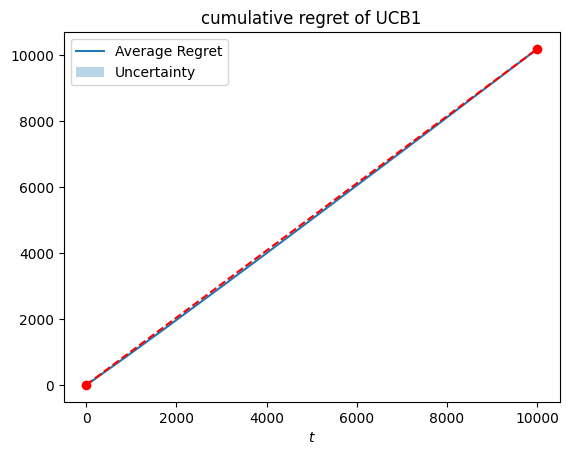

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 2 with shape (3, 10) and arg 3 with shape (100,).

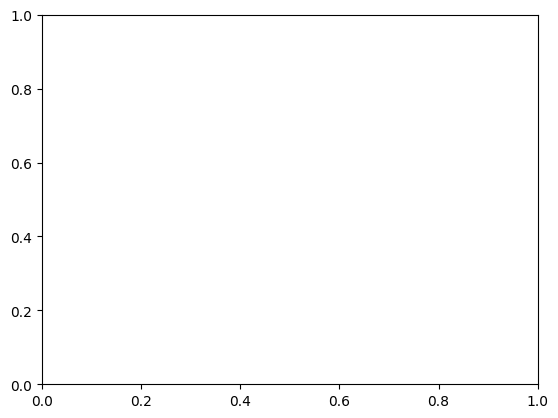

In [196]:
T = 10000
K = 10 # Discretizazion factor
B = 18000
N = 3 # Number of products

prices = np.linspace(0, 1, K)  # Example prices for 3 products

mu = [0.5, 0.2, 0.6]
sigma = np.array([[0.1, 0.05, 0.02],
                  [0.05, 0.1, 0.03],
                  [0.02, 0.03, 0.1]])
buyer = Buyer(mu, sigma)
  
optimal_price_vector, max_total_revenue = compute_baseline(mu, sigma, prices)

best_reward = np.sum(optimal_price_vector)
expected_clairvoyant_rewards = np.repeat(best_reward, T)

n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    print("Trial: ", seed)
    np.random.seed(seed)
    env = MultipleProductsEnv(buyer, num_products=3, prices=prices)
    ucb_agent = CombUCB1Agent(K, B, T, N=3)

    agent_rewards = np.array([])
    
    for t in range(T):
        p_t = np.zeros(N)
        super_arm = ucb_agent.pull_arm()
        for n in range(N):
            pulled_arm = super_arm[n]
            p_t[n] = prices[int(pulled_arm)]

        sold, revenue = env.round(p_t, env.get_valuations())

        item_sold = np.sum(sold)

        if item_sold > 0:
            f_t = revenue
            ucb_agent.update(revenue, sold)
        else:
            f_t = 0
            ucb_agent.update(0, sold)


        agent_rewards = np.append(agent_rewards, f_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)
    print(expected_clairvoyant_rewards.sum())
    print(agent_rewards.sum())
    

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show()

